In [ ]:
import pandas as pd
!pip3 install numpy --upgrade
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import nltk
import re
import contractions
import gensim
import keras
#!pip install GetOldTweets3
import GetOldTweets3 as got

from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_tags, strip_punctuation, stem_text, preprocess_documents, strip_multiple_whitespaces, strip_non_alphanum, strip_short

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from textblob import TextBlob
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#!pip install xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, BatchNormalization, TimeDistributed, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, Conv1D, Dropout
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

pd.options.display.max_colwidth = 600
pd.options.display.max_columns = 500

In [2]:
nltk.download('words')
words = set(nltk.corpus.words.words())
additional_words = ('joebiden', 'biden', 'donaldtrump', 'trump', 'barackobama', 'obama')
for ele in additional_words:
    words.add(ele)

[nltk_data] Downloading package words to /Users/steve/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_non_alphanum, stem_text,
                  remove_stopwords, strip_short]

#stop = stopwords.words('english')
#stop.extend(['amp','aaa'])

def prep(sentence): 
    sentence = contractions.fix(sentence)
    split_sentence = sentence.split()
    return preprocess_string(sentence, CUSTOM_FILTERS)

def prep_withspell(sentence):
    holder = " "
    sentence = contractions.fix(sentence)
    preprocessed = preprocess_string(sentence, CUSTOM_FILTERS)
    spell_correct = TextBlob(holder.join(preprocessed))
    corrected_sentence = spell_correct.correct()
    return corrected_sentence.split()    

def prepare(sentence): 
    processed_feature = re.sub(r'\W', ' ', str(sentence))
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = processed_feature.lower()
    stop_words = set(stopwords.words('english'))
    sentence = processed_feature.split()
    removed_stopwords = [w for w in sentence if not w.lower() in stop_words]    
    return ' '.join(removed_stopwords)

def cont_to_multiclass(cont):
    if cont > 0.66:
        return 'highly positive'
    elif cont > 0.33:
        return 'positive'
    elif cont > 0:
        return 'partly positive'
    elif cont > -0.33:
        return 'partly negative'
    elif cont > -0.66:
        return 'negative'
    else:
        return 'highly negative'

def cont_to_binary(cont):
    if cont > 0:
        #return 'positive'
        return 1
    else:
        #return 'negative'
        return 0

In [4]:
def get_document_frequency(data, wi, wj=None):
    if wj is None:
        D_wi = 0
        for l in range(len(data)):
            doc = data[l]
            if wi in doc:
                D_wi += 1
        return D_wi
    D_wj = 0
    D_wi_wj = 0
    for l in range(len(data)):
        doc = data[l]
        if wj in doc:
            D_wj += 1
            if wi in doc:
                D_wi_wj += 1
    return D_wj, D_wi_wj

def get_topic_coherence(beta, data, vocab, seed):
    D = len(data)
    TC = []
    num_topics = len(beta.components_)
    selected = -1
    selected = []
    for k, topic in enumerate(beta.components_):
        print('k: {}/{}'.format(k, num_topics))
        top_10 = topic.argsort()[:-20 - 1:-1]
        top_words = [vocab[i] for i in top_10]
        print(top_words)
        TC_k = 0
        counter = 0
        for i, word in enumerate(top_words):
            D_wi = get_document_frequency(data, word)
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                D_wj, D_wi_wj = get_document_frequency(data, word, top_words[j])
                if D_wi_wj == 0:
                    f_wi_wj = -1
                else:
                    f_wi_wj = -1 + ( np.log(D_wi) + np.log(D_wj)  - 2.0 * np.log(D) ) / ( np.log(D_wi_wj) - np.log(D) )
                tmp += f_wi_wj
                j += 1
                counter += 1
            TC_k += tmp 
        TC.append(TC_k)
    print('num topics: ', len(TC))
    print('Topic Coherence is: {}'.format(TC))
    return TC, selected

In [5]:
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']
    #print("Overall sentiment dictionary is : ", sentiment_dict)
    #print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    #print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    #print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
    #print("Sentence Overall Rated As", end = " ")
 
    #if sentiment_dict['compound'] >= 0.05 :
        #return "Positive"
    #elif sentiment_dict['compound'] <= - 0.05 :
        #return "Negative"
    #else :
        #return "Neutral"

In [6]:
def word_vector(model, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [7]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return np.array(regressors)    

In [8]:
import os
os.chdir('/Users/steve/GetOldTweets3-0.0.10')

key_words = ['leftwing', 'rightwing', 'liberal', 'leftist', 'conservative', 'politics', 'political', 'antifa', 'gop',
            'democrat', 'trump', 'maga', 'republican', 'politicians', 'vote', 'government', 'breakingnews', 'worldnews', 
            'news', 'fakenews', 'obama', 'tcot', 'p2']

key_word_test = ['leftwing', 'rightwing']

leftwing_df = pd.read_csv('leftwing.csv', error_bad_lines=False, header=None, index_col=False, sep="<|>", lineterminator='\n')
rightwing_df = pd.read_csv('rightwing.csv', error_bad_lines=False, header=None, index_col=False, sep="<|>", lineterminator='\n')
#liberal_df = pd.read_csv('liberal.csv', error_bad_lines=False, header=None, index_col=False, sep= '<|>'', lineterminator='\n')
#leftist_df = pd.read_csv('leftist.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#conservative_df = pd.read_csv('conservative.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#politics_df = pd.read_csv('politics.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#political_df = pd.read_csv('political.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#gop_df = pd.read_csv('gop.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#democrat_df = pd.read_csv('democrat.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#trump_df = pd.read_csv('trump.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#republican_df = pd.read_csv('republican.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#politicians_df = pd.read_csv('politicians.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#fakenews = pd.read_csv('obama.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#tcot = pd.read_csv('tcot.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')
#p2 = pd.read_csv('p2.csv', error_bad_lines=False, header=None, index_col=False, sep='<|>', lineterminator='\n')

#frames = [leftwing_df, rightwing_df, liberal_df, leftist_df, conservative_df, politics_df, political_df, antifa_df, gop_df, democrat_df, trump_df, republican_df, politicians_df, vote_df, government_df, breakingnews_df, worldnews, news, fakenews, obama, tcot, p2]
#result = pd.concat(frames, keys=key_words)

frames_test = [leftwing_df, rightwing_df]
result_test = pd.concat(frames_test, keys=key_word_test)
result_test = result_test.drop_duplicates()
holder = result_test[result_test[0].apply(lambda row: len(row.split()) < 4)]
result_test = pd.concat((result_test, holder))
result_test = result_test.drop_duplicates(keep=False)
result_test[3] = result_test[2].apply(lambda row: str(row).split()[:6])
result_test[3] = result_test[3].apply(lambda row: ' '.join([str(elem) for elem in row]))
result_test = result_test.drop_duplicates(subset=[1, 3], keep=False)

<ipython-input-8-174ca8b73105>:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  leftwing_df = pd.read_csv('leftwing.csv', error_bad_lines=False, header=None, index_col=False, sep="<|>", lineterminator='\n')
<ipython-input-8-174ca8b73105>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rightwing_df = pd.read_csv('rightwing.csv', error_bad_lines=False, header=None, index_col=False, sep="<|>", lineterminator='\n')


In [9]:
result_test[0] = result_test.apply(lambda row: row[0].split()[1], axis=1)                                                
result_test[2] = result_test.apply(lambda row: re.sub(r'http\S+', '', str(row[2])), axis=1)
result_test[2] = result_test.apply(lambda row: ''.join([c for c in row[2] if not c.isdigit()]), axis=1)
result_test[3] = result_test.apply(lambda row : " ".join(w for w in nltk.wordpunct_tokenize(row[2]) if w.lower() in words or not w.isalpha()), axis = 1)
result_test[4] = result_test.apply(lambda row : prep(row[3]), axis = 1)
result_test = result_test[result_test[4].map(len) >= 5]

In [10]:
processed_data_test = [" ".join(x) for x in result_test[4]]

In [11]:
tfidf = TfidfVectorizer(max_df=0.90, min_df=3, stop_words='english', ngram_range=(1,3))
dtm = tfidf.fit_transform(processed_data_test)

tf_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
tf_fit = tf_vectorizer.fit_transform(processed_data_test)
print(dtm.shape)
print(tf_fit.shape)

(109948, 74437)
(109948, 1234871)


In [12]:
nmf_model = NMF(n_components=50, random_state=42, beta_loss='kullback-leibler', solver='mu', 
                max_iter=1000, alpha=2, l1_ratio=0.5)
nmf_topics = nmf_model.fit_transform(dtm)

/Users/steve/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [13]:
nmf = NMF(n_components=50, random_state=42, beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=2, l1_ratio=0.5).fit(dtm)

In [14]:
nmf_test_df = pd.DataFrame(nmf.components_, columns=tfidf.get_feature_names())

In [15]:
nmf_df = pd.DataFrame(nmf_model.components_, columns=tfidf.get_feature_names())

In [16]:
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index} GIVEN BY NMF:')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0 GIVEN BY NMF:
['leftist femin', 'polit donaldtrump', 'liber leftist', 'polit', 'femin', 'donaldtrump', 'trump polit', 'leftist', 'liber', 'world']


THE TOP 10 WORDS FOR TOPIC #1 GIVEN BY NMF:
['joe biden', 'joe', 'readi polit democrat', 'trump', 'readi polit', 'readi', 'biden', 'polit', 'polit democrat', 'democrat']


THE TOP 10 WORDS FOR TOPIC #2 GIVEN BY NMF:
['stupid', 'thought', 'onc', 'problem', 'sad', 'wonder', 'point', 'understand', 'everyon', 'turn']


THE TOP 10 WORDS FOR TOPIC #3 GIVEN BY NMF:
['republican liber leftist', 'conserv republican liber', 'republican liber', 'polit conserv republican', 'trump polit conserv', 'polit conserv', 'trump', 'conserv republican', 'conserv', 'republican']


THE TOP 10 WORDS FOR TOPIC #4 GIVEN BY NMF:
['presid joe biden', 'presid joe', 'presid biden', 'joe biden', 'joe', 'presid', 'polit', 'add polit', 'add', 'biden']


THE TOP 10 WORDS FOR TOPIC #5 GIVEN BY NMF:
['upcom commun chat', 'upcom commun', 'polit upc

In [17]:
seed = "immigr"
tc,ind_seed = get_topic_coherence(nmf, processed_data_test, tfidf.get_feature_names(), seed)

k: 0/50
['world', 'liber', 'leftist', 'trump polit', 'donaldtrump', 'femin', 'polit', 'liber leftist', 'polit donaldtrump', 'leftist femin', 'liber leftist femin', 'femin polit', 'leftist femin polit', 'femin polit donaldtrump', 'world trump', 'world trump polit', 'trump', 'polit new', 'new liber', 'trump polit new']
k: 1/50
['democrat', 'polit democrat', 'polit', 'biden', 'readi', 'readi polit', 'trump', 'readi polit democrat', 'joe', 'joe biden', 'add polit democrat', 'lead', 'final', 'team', 'victori', 'despit', 'offici', 'foreign', 'trump biden', 'win']
k: 2/50
['turn', 'everyon', 'understand', 'point', 'wonder', 'sad', 'problem', 'onc', 'thought', 'stupid', 'sure', 'shame', 'true', 'someon', 'complet', 'consid', 'absolut', 'hard', 'seen', 'famili']
k: 3/50
['republican', 'conserv', 'conserv republican', 'trump', 'polit conserv', 'trump polit conserv', 'polit conserv republican', 'republican liber', 'conserv republican liber', 'republican liber leftist', 'liber', 'donaldtrump', 'tr

In [18]:
lda_model = LatentDirichletAllocation(n_components=50, doc_topic_prior=.01)
lda_topics = lda_model.fit_transform(tf_fit)

In [19]:
lda_df = pd.DataFrame(lda_model.components_, columns=tf_vectorizer.get_feature_names())

In [20]:
for index, topic in enumerate(lda_model.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index} GIVEN BY LDA:')
    print([tf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0 GIVEN BY LDA:
['joe biden', 'post', 'joe', 'hous', 'new', 'presid', 'biden', 'polit', 'add polit', 'add']


THE TOP 10 WORDS FOR TOPIC #1 GIVEN BY LDA:
['polit', 'like', 'capit', 'right', 'new', 'media', 'trump', 'peopl', 'thei', 'thi']


THE TOP 10 WORDS FOR TOPIC #2 GIVEN BY LDA:
['good', 'left', 'support', 'sai', 'time', 'thi', 'peopl', 'polit', 'thei', 'trump']


THE TOP 10 WORDS FOR TOPIC #3 GIVEN BY LDA:
['new', 'biden', 'campaign', 'readi polit democrat', 'readi polit', 'trump', 'readi', 'polit democrat', 'democrat', 'polit']


THE TOP 10 WORDS FOR TOPIC #4 GIVEN BY LDA:
['trump', 'new', 'like', 'time', 'right', 'thi', 'media', 'peopl', 'polit', 'thei']


THE TOP 10 WORDS FOR TOPIC #5 GIVEN BY LDA:
['obama', 'know', 'media', 'becaus', 'left', 'thei', 'right', 'like', 'thi', 'polit']


THE TOP 10 WORDS FOR TOPIC #6 GIVEN BY LDA:
['freedom', 'like', 'republican', 'thei', 'trump republican', 'conserv trump', 'polit', 'conserv', 'trump', 'thi']


THE TO

In [21]:
## Naming topics 
#Topic0-  oil_gas_prices 
#Topic1 - grocery_store_workers
#Topic2- toilet_paper_sanitiser
#Topic3- online_shopping 
#Topic4- panic_buying_hoarding

naming={0:'Topic0', 1:'Topic1', 2:'Topic2', 3:'Topic3', 4:'Topic4', 5:'Topic5', 6:'Topic6', 7:'Topic7',
        8:'Topic8', 9:'Topic9', 10:'Topic10', 11:'Topic11', 12:'Topic12', 13:'Topic13', 14:'Topic14', 15:'Topic15',
        16:'Topic16', 17:'Topic17', 18:'Topic18', 19:'Topic19', 20:'Topic20', 21:'Topic21', 22:'Topic22', 23:'Topic23',
        24:'Topic24', 25:'Topic25', 26:'Topic26', 27:'Topic27', 28:'Topic28', 29:'Topic29', 30:'Topic30', 31:'Topic31',
        32:'Topic32', 33:'Topic33', 34:'Topic34', 35:'Topic35', 36:'Topic36', 37:'Topic37', 38:'Topic38', 39:'Topic39',
        40:'Topic40', 41:'Topic41', 42:'Topic42', 43:'Topic43', 44:'Topic44', 45:'Topic45', 46:'Topic46', 47:'Topic47',
        48:'Topic48', 49:'Topic49'}

result_test[5] = nmf_topics.argmax(axis=1)
result_test[5] = result_test[5].map(naming)
result_test[6] = result_test[4].apply(lambda row: ' '.join(row))

In [22]:
labeled_sentiment = result_test.sample(n=50000)
labeled_sentiment[6] = labeled_sentiment.apply(lambda row : sentiment_scores(row[2]), axis = 1)
result_test.join(labeled_sentiment[6], how='left', lsuffix='_left', rsuffix='_right')

0               1  \
leftwing  0       2021-07-14      LeftWing_b   
          1       2021-07-14      LeftWing_b   
          2       2021-07-14      LeftWing_b   
          3       2021-07-14      LeftWing_b   
          4       2021-07-14      LeftWing_b   
...                      ...             ...   
rightwing 119513  2011-07-14  StarStuff_ivan   
          119514  2011-07-14   Brooklynwatch   
          119518  2011-07-14      Scott23875   
          119519  2011-07-14         Salbima   
          119520  2011-07-14     LiberaLLamp   

                                                                                                                                                                                                                                                   2  \
leftwing  0        AOC, Bernice King Slam McCarthy for Saying MLK Would Oppose Critica... (Truthout)  Bernice King and Rep. Alexandria Ocasio-Cortez (D-New York) sharply criticized House Minorit...  Add your highlights:   #LeftWing #Politics...   
          1        Thousands in Cuba Protest Amid Deep Economic Crisis and Ongoing US ... (Truthout)  We go to Havana, Cuba, to look at what is behind protests that brought thousands of people i...  Add your highlights:   #LeftWing #Politics...   
          2             Biden Should Dismantle US Bases in Iraq and Bring the Troops Home (Truthout)  At Bagram Air Base, Afghan scrap merchants are already picking through the graveyard of U.S....  Add your highlights:   #LeftWing #Politics...   
          3            Sanders Calls $. Trillion Reconciliation Bill a "Pivotal Moment" ... (Truthout)  The Senate Democratic leadership agreed late Tuesday to push for a $. trillion legislative...  Add your highlights:   #LeftWing #Politics...   
          4          Republicans Who Worked on Bipartisan Infrastructure Now Won't Com... (Truthout)  Several Senate Republicans who initially said they'd support the watered down, bipartisan ve...  Add your highlights:   #LeftWing #Politics...   
...                                                                                                                                                                                                                                              ...   
rightwing 119513                                                                                                                #Conservative State Legislatures that Upend Constitution And the #RightWing Ideologues That Fuel Their Fringe Ideas    
          119514                                                                                           #rightwing babble abt POTUS really sickening. #teaparty  Never heard any other POTUS called "arrogant" when dealing w/congress WHY? #race   
          119518                                                                                        “@SkyNewsBreak: Sky sources: Daily Mail to increase cover price because of difficult advertising market and newsprint costs” ROFL #rightwing   
          119519                                                                                                                    #ALEC Exposed: A Nationwide Blueprint for the #Rightwing #Takeover | Common Dreams:  via @AddThis #usa #politics   
          119520                                                                                                            @AngryVoters Educate yrself on #Obama  Haters & #RightWing Sock Puppets Whine while #Liberals celebrate @LiberalPagan #p   

                                                                                                                                                                                                        3  \
leftwing  0                                                            , King Slam for Saying Would Oppose ... ( ) King and Rep . - Cortez ( D - New York ) sharply House ... Add your : # # Politics ...   
          1                                   in Protest Amid D

In [23]:
first_value = result_test[2]
second_value = result_test[5]
list_topic_labeled_test = [first_value, second_value]
df_topic_labeled_test = pd.DataFrame(list(zip(first_value, second_value)), columns =['Tweet', 'Topic_Name'])
display = df_topic_labeled_test.set_index(['Topic_Name'])
value = display.loc['Topic5']
display = value.sample(n=1000)
#for ele in display['Tweet']:
    #print(ele)
    #print('\n')

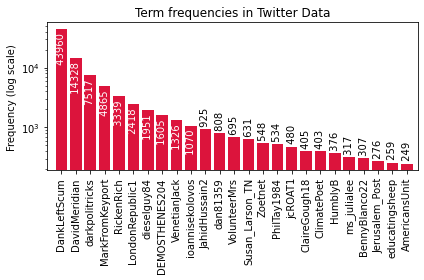

In [24]:
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

words = result_test[1].drop_duplicates()
indices = np.random.zipf(1.6, size=100000).astype(np.int) % len(words)
tweets = np.array(words)[indices]

tf_count = Counter(tweets)

y = [count for tag, count in tf_count.most_common(25)]
x = [tag for tag, count in tf_count.most_common(25)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in Twitter Data")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf_count.most_common(25)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
#plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.xlim(-1.0, len(x)-0.25) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

In [25]:
features1 = labeled_sentiment.iloc[:, 2].values
features2 = labeled_sentiment.iloc[:, 4].values
topic = labeled_sentiment.iloc[:, 5].values
labels = labeled_sentiment.iloc[:, 6].values
d = {'original_tweet': features1, 'identified_topic': topic, 'features1': features1, 'features2': features2, 'labels': labels}
df = pd.DataFrame(data=d)
df['features1'] = df['features1'].apply(lambda row: prepare(row))
df['features2_sen'] = df['features2'].apply(lambda row: ' '.join(row))
df['multiclass_labels'] = df['labels'].apply(lambda row: cont_to_multiclass(row))
df['binary_labels'] = df['labels'].apply(lambda row: cont_to_binary(row))

In [26]:
result_test

0               1  \
leftwing  0       2021-07-14      LeftWing_b   
          1       2021-07-14      LeftWing_b   
          2       2021-07-14      LeftWing_b   
          3       2021-07-14      LeftWing_b   
          4       2021-07-14      LeftWing_b   
...                      ...             ...   
rightwing 119513  2011-07-14  StarStuff_ivan   
          119514  2011-07-14   Brooklynwatch   
          119518  2011-07-14      Scott23875   
          119519  2011-07-14         Salbima   
          119520  2011-07-14     LiberaLLamp   

                                                                                                                                                                                                                                                   2  \
leftwing  0        AOC, Bernice King Slam McCarthy for Saying MLK Would Oppose Critica... (Truthout)  Bernice King and Rep. Alexandria Ocasio-Cortez (D-New York) sharply criticized House Minorit...  Add your highlights:   #LeftWing #Politics...   
          1        Thousands in Cuba Protest Amid Deep Economic Crisis and Ongoing US ... (Truthout)  We go to Havana, Cuba, to look at what is behind protests that brought thousands of people i...  Add your highlights:   #LeftWing #Politics...   
          2             Biden Should Dismantle US Bases in Iraq and Bring the Troops Home (Truthout)  At Bagram Air Base, Afghan scrap merchants are already picking through the graveyard of U.S....  Add your highlights:   #LeftWing #Politics...   
          3            Sanders Calls $. Trillion Reconciliation Bill a "Pivotal Moment" ... (Truthout)  The Senate Democratic leadership agreed late Tuesday to push for a $. trillion legislative...  Add your highlights:   #LeftWing #Politics...   
          4          Republicans Who Worked on Bipartisan Infrastructure Now Won't Com... (Truthout)  Several Senate Republicans who initially said they'd support the watered down, bipartisan ve...  Add your highlights:   #LeftWing #Politics...   
...                                                                                                                                                                                                                                              ...   
rightwing 119513                                                                                                                #Conservative State Legislatures that Upend Constitution And the #RightWing Ideologues That Fuel Their Fringe Ideas    
          119514                                                                                           #rightwing babble abt POTUS really sickening. #teaparty  Never heard any other POTUS called "arrogant" when dealing w/congress WHY? #race   
          119518                                                                                        “@SkyNewsBreak: Sky sources: Daily Mail to increase cover price because of difficult advertising market and newsprint costs” ROFL #rightwing   
          119519                                                                                                                    #ALEC Exposed: A Nationwide Blueprint for the #Rightwing #Takeover | Common Dreams:  via @AddThis #usa #politics   
          119520                                                                                                            @AngryVoters Educate yrself on #Obama  Haters & #RightWing Sock Puppets Whine while #Liberals celebrate @LiberalPagan #p   

                                                                                                                                                                                                        3  \
leftwing  0                                                            , King Slam for Saying Would Oppose ... ( ) King and Rep . - Cortez ( D - New York ) sharply House ... Add your : # # Politics ...   
          1                                   in Protest Amid D

In [27]:
df

,original_tweet,identified_topic,features1,features2,labels,features2_sen,multiclass_labels,binary_labels
0,The Supreme Court Case That Enshrined White Supremacy in Law + LeftyBot #LeftWing #Politics,Topic47,supreme court case enshrined white supremacy law leftybot leftwing politics,"[suprem, court, case, white, supremaci, law, polit]",0.5859,suprem court case white supremaci law polit,positive,1
1,Trump claims doctors 'get more money' for COVID deaths #LeftWing #Politics #democrat #bernie,Topic44,trump claims doctors get money covid deaths leftwing politics democrat bernie,"[trump, monei, covid, polit, democrat]",0.0000,trump monei covid polit democrat,partly negative,0
2,"@zesty_leftwing We need to make the #rightwing aware of #trumps plan, but they are all hypnotized..",Topic32,zesty_leftwing need make rightwing aware trumps plan hypnotized,"[zesti, leftw, need, awar, plan, thei]",0.0000,zesti leftw need awar plan thei,partly negative,0
3,@Curious_Kurz I think BillyBoy could use some unsolicited money advice... And the @TheDCSentinel might enjoy piling onto this hilarious thread...the responses to this moron are gold! @samknight_one @SamSacks #asshat #rightwing #idiot #millioninsparechange?,Topic9,curious_kurz think billyboy could use unsolicited money advice thedcsentinel might enjoy piling onto hilarious thread responses moron gold samknight_one samsacks asshat rightwing idiot millioninsparechange,"[curiou, kurz, think, billyboi, unsolicit, monei, advic, enjoi, pile, thi, hilari, thread, thi, moron, gold, samknight, idiot]",-0.2540,curiou kurz think billyboi unsolicit monei advic enjoi pile thi hilari thread thi moron gold samknight idiot,partly negative,0
4,@RepJoeKennedy @realDonaldTrump Youre so #Corrupt condemning everything @realDonaldTrump does knowing darn well that #Trump didn't cause the #DemocratShutdown. YOU #Left &amp; your spineless #Radical #Leftwing leaders who won't agree on #TheWall you already agreed upon for obumer. #Dems won't compromise an inch,Topic34,repjoekennedy realdonaldtrump youre corrupt condemning everything realdonaldtrump knowing darn well trump cause democratshutdown left amp spineless radical leftwing leaders agree thewall already agreed upon obumer dems compromise inch,"[corrupt, condemn, everyth, doe, know, darn, trump, becaus, left, spineless, radic, won, agre, alreadi, agre, won, compromis, inch]",0.2709,corrupt condemn everyth doe know darn trump becaus left spineless radic won agre alreadi agre won compromis inch,partly positive,1
...,...,...,...,...,...,...,...,...
49995,So tired of fighting lies from people so invested that they lose integrity. Dear #rightwing can't we just argue the issues please.,Topic18,tired fighting lies people invested lose integrity dear rightwing argue issues please,"[tire, fight, peopl, thei, lose, integr, dear, argu, pleas]",-0.4443,tire fight peopl thei lose integr dear argu pleas,negative,0
49996,@WAtoday Endangered species hunted in Australia daily but no one gives a crap because they the #WokeMob #Greens #leftwing say it's traditional which is bullshit no need for it plenty of food around with no need for this #auspol,Topic32,watoday endangered species hunted australia daily one gives crap wokemob greens leftwing say traditional bullshit need plenty food around need auspol,"[speci, daili, crap, becaus, thei, sai, tradit, need, plenti, food, need, thi]",-0.9517,speci daili crap becaus thei sai tradit need plenti food need thi,highly negative,0
49997,"If anyone gets a copy of this shit newspaper, and you’re not sure what to do with it, it makes great litter box liner, outhouse toilet paper, and would be excellent for kindling! #epochtimes #trash #racism #rightwing",Topic9,anyone gets copy shit newspaper sure makes great litter box liner outhouse toilet paper would excellent kindling epochtimes trash racism rightwing,"[anyon, copi, thi, newspap, sure, great, litter, box, liner, outhous, toilet, paper, excel, kindl, trash, racism]",-0.4222,anyon copi thi

In [28]:
tfidf = TfidfVectorizer(max_df=0.90, min_df=20, stop_words=stopwords.words('english'), ngram_range=(1,3))
dtm = tfidf.fit_transform(df['features2_sen']).toarray()

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=20, stop_words=stopwords.words('english'), ngram_range=(1,3))
bow = bow_vectorizer.fit_transform(df['features2_sen']).toarray()

test = np.concatenate((dtm, bow), axis=1)

tokenizer = Tokenizer(num_words=10000, split=' ')
tokenizer.fit_on_texts(df['features2_sen'].values)
bow_tok = tokenizer.texts_to_sequences(df['features2_sen'])
bow_tok = pad_sequences(bow_tok)

tokenized_tweet = df['features2_sen'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(df['features2_sen'], vector_size=300, window=5, min_count=5, sg=1,
                                   hs=0, negative=10, seed=42)
model_w2v.train(tokenized_tweet, total_examples=len(df['features2_sen']), epochs=20)
sent2vec = np.empty((len(tokenized_tweet), 300))
for ele in range(len(tokenized_tweet)):
    sen_length = len(tokenized_tweet[ele])
    current_words = np.empty((sen_length, 300))
    for word in range(sen_length):
        current_words[word] = word_vector(model_w2v, tokenized_tweet[ele][word], 300)[0]
    sent2vec[ele] = np.mean(current_words, axis=0)

ft_model = FastText(tokenized_tweet, vector_size=300, window=50, min_count=5, sg=1)
fasttext = np.zeros((len(tokenized_tweet), 300)) 
for ele in range(len(tokenized_tweet)):
    sen_length = len(tokenized_tweet[ele])
    current_words = np.empty((sen_length, 300))
    for word in range(sen_length):
        current_words[word] = (word_vector(ft_model, tokenized_tweet[ele][word], 300)[0])
    fasttext[ele] = np.mean(current_words, axis=0)

from gensim.models.doc2vec import TaggedDocument
import multiprocessing
cores = multiprocessing.cpu_count()
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
tqdm.pandas(desc="progress-bar")

train_tagged = df.apply(lambda row: TaggedDocument(words=row['features2'], tags=row['identified_topic']), axis=1)
doc2vec_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=5, sample = 0, workers=cores)
doc2vec_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
for epoch in range(30):
    doc2vec_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    doc2vec_dbow.alpha -= 0.002
    doc2vec_dbow.min_alpha = doc2vec_dbow.alpha
doc2vec_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=5, workers=5, alpha=0.065, min_alpha=0.065)
doc2vec_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
for epoch in range(30):
    doc2vec_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    doc2vec_dmm.alpha -= 0.002
    doc2vec_dmm.min_alpha = doc2vec_dmm.alpha
doc2vec = ConcatenatedDoc2Vec([doc2vec_dbow, doc2vec_dmm])
doc2vec = get_vectors(doc2vec, train_tagged)

100%|██████████| 50000/50000 [00:00<00:00, 2387087.67it/s]


In [29]:
tfidf2 = TfidfVectorizer(max_df=0.90, min_df=20, stop_words=stopwords.words('english'), ngram_range=(1,3))
dtm2 = tfidf.fit_transform(result_test[6]).toarray()

bow_vectorizer2 = CountVectorizer(max_df=0.90, min_df=20, stop_words=stopwords.words('english'), ngram_range=(1,3))
bow2 = bow_vectorizer.fit_transform(result_test[6]).toarray()

test2 = np.concatenate((dtm2, bow2), axis=1)

tokenizer2 = Tokenizer(num_words=10000, split=' ')
tokenizer2.fit_on_texts(result_test[6].values)
bow_tok2 = tokenizer2.texts_to_sequences(result_test[6])
bow_tok2 = pad_sequences(bow_tok2)

tokenized_tweet2 = result_test[6].apply(lambda x: x.split())
model_w2v2 = gensim.models.Word2Vec(result_test[6], vector_size=300, window=5, min_count=5, sg=1,
                                   hs=0, negative=10, seed=42)
model_w2v2.train(tokenized_tweet2, total_examples=len(result_test[6]), epochs=20)
sent2vec2 = np.empty((len(tokenized_tweet2), 300))
for ele in range(len(tokenized_tweet2)):
    sen_length = len(tokenized_tweet2[ele])
    current_words = np.empty((sen_length, 300))
    for word in range(sen_length):
        current_words[word] = word_vector(model_w2v2, tokenized_tweet2[ele][word], 300)[0]
    sent2vec2[ele] = np.mean(current_words, axis=0)

ft_model2 = FastText(tokenized_tweet2, vector_size=300, window=50, min_count=5, sg=1)
fasttext2 = np.zeros((len(tokenized_tweet2), 300)) 
for ele in range(len(tokenized_tweet2)):
    sen_length = len(tokenized_tweet2[ele])
    current_words = np.empty((sen_length, 300))
    for word in range(sen_length):
        current_words[word] = (word_vector(ft_model2, tokenized_tweet2[ele][word], 300)[0])
    fasttext2[ele] = np.mean(current_words, axis=0)

from gensim.models.doc2vec import TaggedDocument
import multiprocessing
cores = multiprocessing.cpu_count()
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
tqdm.pandas(desc="progress-bar")

train_tagged2 = result_test.apply(lambda row: TaggedDocument(words=row[4], tags=row[5]), axis=1)
doc2vec_dbow2 = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=5, sample = 0, workers=cores)
doc2vec_dbow2.build_vocab([x for x in tqdm(train_tagged2.values)])
for epoch in range(30):
    doc2vec_dbow2.train(utils.shuffle([x for x in tqdm(train_tagged2.values)]), total_examples=len(train_tagged2.values), epochs=1)
    doc2vec_dbow2.alpha -= 0.002
    doc2vec_dbow2.min_alpha = doc2vec_dbow2.alpha
doc2vec_dmm2 = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=5, workers=5, alpha=0.065, min_alpha=0.065)
doc2vec_dmm2.build_vocab([x for x in tqdm(train_tagged2.values)])
for epoch in range(30):
    doc2vec_dmm2.train(utils.shuffle([x for x in tqdm(train_tagged2.values)]), total_examples=len(train_tagged2.values), epochs=1)
    doc2vec_dmm2.alpha -= 0.002
    doc2vec_dmm2.min_alpha = doc2vec_dmm2.alpha
doc2vec2 = ConcatenatedDoc2Vec([doc2vec_dbow2, doc2vec_dmm2])
doc2vec2 = get_vectors(doc2vec2, train_tagged2)

100%|██████████| 109948/109948 [00:00<00:00, 1591793.59it/s]


In [30]:
embed_array = np.hstack((dtm, bow, sent2vec, fasttext, doc2vec))

In [31]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(embed_array, df['binary_labels'], test_size=0.1, random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [33]:
rf_pred = pd.DataFrame(np.empty((len(df['binary_labels']), 5)), columns=['dtm', 'bow', 'sent2vec', 'fasttext', 'doc2vec'])
etc_pred = pd.DataFrame(np.empty((len(df['binary_labels']), 5)), columns=['dtm', 'bow', 'sent2vec', 'fasttext', 'doc2vec'])
sgd_pred = pd.DataFrame(np.empty((len(df['binary_labels']), 5)), columns=['dtm', 'bow', 'sent2vec', 'fasttext', 'doc2vec'])
xgb_pred = pd.DataFrame(np.empty((len(df['binary_labels']), 5)), columns=['dtm', 'bow', 'sent2vec', 'fasttext', 'doc2vec'])

In [34]:
X_train_dtm = X_train[:, 0:dtm.shape[1]]
X_train_bow = X_train[:, dtm.shape[1]:(dtm.shape[1]+bow.shape[1])]
X_train_w2v = X_train[:, (dtm.shape[1]+bow.shape[1]):(dtm.shape[1]+bow.shape[1]+sent2vec.shape[1])]
X_train_ft = X_train[:, (dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]):(dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]+fasttext.shape[1])]
X_train_d2v = X_train[:, (dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]+fasttext.shape[1]):(dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]+fasttext.shape[1]+doc2vec.shape[1])]
X_test_dtm = X_test[:, 0:dtm.shape[1]]
X_test_bow = X_test[:, dtm.shape[1]:(dtm.shape[1]+bow.shape[1])]
X_test_w2v = X_test[:, (dtm.shape[1]+bow.shape[1]):(dtm.shape[1]+bow.shape[1]+sent2vec.shape[1])]
X_test_ft = X_test[:, (dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]):(dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]+fasttext.shape[1])]
X_test_d2v = X_test[:, (dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]+fasttext.shape[1]):(dtm.shape[1]+bow.shape[1]+sent2vec.shape[1]+fasttext.shape[1]+doc2vec.shape[1])]
d = {'dtm': list(X_train_dtm), 'bow': list(X_train_bow), 'w2v': list(X_train_w2v), 'ft': list(X_train_ft), 'd2v': list(X_train_d2v)}
X_train = pd.DataFrame(data=d)
d = {'dtm': list(X_test_dtm), 'bow': list(X_test_bow), 'w2v': list(X_test_w2v), 'ft': list(X_test_ft), 'd2v': list(X_test_d2v)}
X_test = pd.DataFrame(data=d)

In [ ]:
print('TF-IDF Training: ')
X_train_dtm = X_train['dtm'].to_numpy()
X_train_dtm = np.stack(X_train_dtm, axis=0)
X_test_dtm = X_test['dtm'].to_numpy()
X_test_dtm = np.stack(X_test_dtm, axis=0)

print("RandomForest: ")
rf_classifier_dtm = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42)
rf_classifier_dtm.fit(X_train_dtm, y_train)
predictions = rf_classifier_dtm.predict(X_test_dtm)
rf_pred['dtm'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("ExtraTree: ")
etc_dtm = ExtraTreesClassifier(n_estimators=300, random_state=42)
etc_dtm.fit(X_train_dtm, y_train)
predictions = etc_dtm.predict(X_test_dtm)
etc_pred['dtm'] = predictions
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

print("StochasticGradientDescent: ")
sgd_classifier_dtm = SGDClassifier(loss="hinge", penalty="l1")
sgd_classifier_dtm.fit(X_train_dtm, y_train)
predictions = sgd_classifier_dtm.predict(X_test_dtm)
sgd_pred['dtm'] = predictions
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

print("XGBoost: ")
xgb_classifier_dtm = XGBClassifier(n_estimator=200, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb_classifier_dtm.fit(X_train_dtm, y_train)
predictions = xgb_classifier_dtm.predict(X_test_dtm)
xgb_pred['dtm'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

TF-IDF Training: 
RandomForest: 


KeyboardInterrupt: 

In [ ]:
print('BOW Training: ')
X_train_bow = X_train['bow'].to_numpy()
X_train_bow = np.stack(X_train_bow, axis=0)
X_test_bow = X_test['bow'].to_numpy()
X_test_bow = np.stack(X_test_bow, axis=0)

print("RandomForest: ")
rf_classifier_bow = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42)
rf_classifier_bow.fit(X_train_bow, y_train)
predictions = rf_classifier_bow.predict(X_test_bow)
rf_pred['bow'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("ExtraTree: ")
etc_bow = ExtraTreesClassifier(n_estimators=300, random_state=42)
etc_bow.fit(X_train_bow, y_train)
predictions = etc_bow.predict(X_test_bow)
etc_pred['bow'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("StochasticGradientDescent: ")
sgd_classifier_bow = SGDClassifier(loss="hinge", penalty="l1")
sgd_classifier_bow.fit(X_train_bow, y_train)
predictions = sgd_classifier_bow.predict(X_test_bow)
sgd_pred['bow'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("XGBoost: ")
xgb_classifier_bow = XGBClassifier(n_estimator=200, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb_classifier_bow.fit(X_train_bow, y_train)
predictions = xgb_classifier_bow.predict(X_test_bow)
xgb_pred['bow'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
print('Sent2Vec Training: ')
X_train_w2v = X_train['w2v'].to_numpy()
X_train_w2v = np.stack(X_train_w2v, axis=0)
X_test_w2v = X_test['w2v'].to_numpy()
X_test_w2v = np.stack(X_test_w2v, axis=0)

print("RandomForest: ")
rf_classifier_w2v = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42)
rf_classifier_w2v.fit(X_train_w2v, y_train)
predictions = rf_classifier_w2v.predict(X_test_w2v)
rf_pred['sent2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("ExtraTree: ")
etc_w2v = ExtraTreesClassifier(n_estimators=300, random_state=42)
etc_w2v.fit(X_train_w2v, y_train)
predictions = etc_w2v.predict(X_test_w2v)
etc_pred['sent2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("StochasticGradientDescent: ")
sgd_classifier_w2v = SGDClassifier(loss="hinge", penalty="l1")
sgd_classifier_w2v.fit(X_train_w2v, y_train)
predictions = sgd_classifier_w2v.predict(X_test_w2v)
sgd_pred['sent2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("XGBoost: ")
xgb_classifier_w2v = XGBClassifier(n_estimator=200, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb_classifier_w2v.fit(X_train_w2v, y_train)
predictions = xgb_classifier_w2v.predict(X_test_w2v)
xgb_pred['sent2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
print('FastText Training: ')
X_train_ft = X_train['ft'].to_numpy()
X_train_ft = np.stack(X_train_ft, axis=0)
X_test_ft = X_test['ft'].to_numpy()
X_test_ft = np.stack(X_test_ft, axis=0)

print("RandomForest: ")
rf_classifier_ft = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42)
rf_classifier_ft.fit(X_train_ft, y_train)
predictions = rf_classifier_ft.predict(X_test_ft)
rf_pred['fasttext'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("ExtraTree: ")
etc_ft = ExtraTreesClassifier(n_estimators=300, random_state=42)
etc_ft.fit(X_train_ft, y_train)
predictions = etc_ft.predict(X_test_ft)
etc_pred['fasttext'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("StochasticGradientDescent: ")
sgd_classifier_ft = SGDClassifier(loss="hinge", penalty="l1")
sgd_classifier_ft.fit(X_train_ft, y_train)
predictions = sgd_classifier_ft.predict(X_test_ft)
sgd_pred['fasttext'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("XGBoost: ")
xgb_classifier_ft = XGBClassifier(n_estimator=200, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb_classifier_ft.fit(X_train_ft, y_train)
predictions = xgb_classifier_ft.predict(X_test_ft)
xgb_pred['fasttext'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
print('Doc2Vec Training: ')
X_train_d2v = X_train['d2v'].to_numpy()
X_train_d2v = np.stack(X_train_d2v, axis=0)
X_test_d2v = X_test['d2v'].to_numpy()
X_test_d2v = np.stack(X_test_d2v, axis=0)

print("RandomForest: ")
rf_classifier_d2v = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42)
rf_classifier_d2v.fit(X_train_d2v, y_train)
predictions = rf_classifier_d2v.predict(X_test_d2v)
rf_pred['doc2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("ExtraTree: ")
etc_d2v = ExtraTreesClassifier(n_estimators=300, random_state=42)
etc_d2v.fit(X_train_d2v, y_train)
predictions = etc_d2v.predict(X_test_d2v)
etc_pred['doc2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("StochasticGradientDescent: ")
sgd_classifier_d2v = SGDClassifier(loss="hinge", penalty="l1")
sgd_classifier_d2v.fit(X_train_d2v, y_train)
predictions = sgd_classifier_d2v.predict(X_test_d2v)
sgd_pred['doc2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("XGBoost: ")
xgb_classifier_d2v = XGBClassifier(n_estimator=200, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb_classifier_d2v.fit(X_train_d2v, y_train)
predictions = xgb_classifier_d2v.predict(X_test_d2v)
xgb_pred['doc2vec'] = predictions
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(rf_pred, df['binary_labels'], test_size=0.1, random_state=42)
X_etc_train, X_etc_test, y_etc_train, y_etc_test = train_test_split(etc_pred, df['binary_labels'], test_size=0.1, random_state=42)
X_sgd_train, X_sgd_test, y_sgd_train, y_sgd_test = train_test_split(sgd_pred, df['binary_labels'], test_size=0.1, random_state=42)
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(xgb_pred, df['binary_labels'], test_size=0.1, random_state=42)

rf_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
rf_model.fit(X_rf_train, y_rf_train)
predictions = rf_model.predict(X_rf_test)
print(confusion_matrix(y_rf_test, predictions))
print(classification_report(y_rf_test, predictions))
print(accuracy_score(y_rf_test, predictions))

etc_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
etc_model.fit(X_etc_train, y_etc_train)
predictions = etc_model.predict(X_etc_test)
print(confusion_matrix(y_etc_test, predictions))
print(classification_report(y_etc_test, predictions))
print(accuracy_score(y_etc_test, predictions))

sgd_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
sgd_model.fit(X_sgd_train, y_sgd_train)
predictions = sgd_model.predict(X_sgd_test)
print(confusion_matrix(y_sgd_test, predictions))
print(classification_report(y_sgd_test, predictions))
print(accuracy_score(y_sgd_test, predictions))

xgb_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
xgb_model.fit(X_xgb_train, y_sgd_train)
predictions = xgb_model.predict(X_xgb_test)
print(confusion_matrix(y_xgb_test, predictions))
print(classification_report(y_xgb_test, predictions))
print(accuracy_score(y_xgb_test, predictions))

"""
from mlxtend.classifier import EnsembleVoteClassifier
import copy
model1 = rf_classifier_dtm
model2 = rf_classifier_bow
model3 = rf_classifier_w2v
model4 = rf_classifier_ft
model5 = rf_classifier_d2v
eclf = EnsembleVoteClassifier(clfs=[model1, model2, model3, model4, model5], weights=[1,1,1], fit_base_estimators=False)

labels = ['TF-IDF', 'BOW', 'W2V', 'FT', 'D2V']
for clf, label in zip([model1, model2, model3, model4, model5, eclf], labels):
    scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))
    


from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
kfold = model_selection.KFold(n_splits=10, random_state=seed)
estimators = []
model1 = rf_classifier_dtm
estimators.append(('dtm', model1))
model2 = rf_classifier_bow
estimators.append(('bow', model2))
model3 = rf_classifier_w2v
estimators.append(('w2v', model3))
model4 = rf_classifier_ft
estimators.append(('ft', model4))
model5 = rf_classifier_d2v
estimators.append(('d2v', model5))

ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)"""

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dtm, df['multiclass_labels'], test_size=0.1, random_state=42)

X_train, y_train = smt.fit_resample(X_train, y_train)

print("RandomForest: ")
rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=300, random_state=42)
rf_classifier.fit(X_train, y_train)
predictions = rf_classifier.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("ExtraTree: ")
etc = ExtraTreesClassifier(n_estimators=300, random_state=42)
etc.fit(X_train, y_train)
predictions = etc.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("StochasticGradientDescent: ")
sgd_classifier = SGDClassifier(loss="hinge", penalty="l1")
sgd_classifier.fit(X_train, y_train)
predictions = sgd_classifier.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

print("XGBoost: ")
xgb_classifier = XGBClassifier(n_estimator=200, learning_rate=0.1, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train, y_train)
predictions = xgb_classifier.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
# Plotting utility
from IPython.display import clear_output
class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        fig, axes = plt.subplots(1,2,figsize=(8,3))
        
        axes[0].plot(self.x, self.losses, label="Train loss")
        axes[0].plot(self.x, self.val_losses, label="Validation loss")
        axes[0].set_xlabel('Number of epochs')
        axes[0].set_ylabel('Losses')
        axes[0].legend()
            
        axes[1].plot(self.x, self.acc, label="Train accuracy")
        axes[1].plot(self.x, self.val_acc, label="Validation accuracy")
        axes[1].set_xlabel('Number of epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show();

In [ ]:
embed_dim = 128
lstm_out = 196
input_size = 37
vocab_size = 7125
plot_losses = PlotLosses()
model = Sequential()

model.add(Embedding(vocab_size, embed_dim, input_length=input_size))

model.add(Conv1D(20, 6, padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(20, 6, padding='same', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(lstm_out, dropout=0.25, recurrent_dropout=0.25, kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=2e-6)))
#model.add(Dropout(0.25))
#model.add(BatchNormalization())
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
Le = LabelEncoder()
y = Le.fit_transform(df['binary_labels'])
#X_train, X_test, y_train, y_test = train_test_split(bow_tok, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.1, random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=25, batch_size=124, callbacks=[plot_losses, es_callback])

In [ ]:
model.summary()

results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

predictions = model.predict(X_test)
for ele in predictions:
    if ele[0] > 0.5:
        ele[0] = 1
    else:
        ele[0] = 0

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
embed_array2 = np.hstack((dtm2, bow2, sent2vec2, fasttext2, doc2vec2))

In [ ]:
count_neg = 0
count_pos = 0
for ele in df['binary_labels']:
    if ele > 0:
        count_pos += 1
    else:
        count_neg +=1
print(count_neg)
print(count_pos)

In [ ]:
result_test

In [ ]:
labeled_sentiment

In [ ]:
max(labeled_sentiment.index)

In [ ]:
max(result_test.index)

In [ ]:
test = result_test.join(labeled_sentiment[6], how='left', lsuffix='_left', rsuffix='_right')

In [ ]:
test = result_test.apply(lambda row: TaggedDocument(words=row[4], tags=row[5]), axis=1)

In [ ]:
for ele in test:
    print(ele)

In [11]:
from gensim.models import FastText
from gensim.test.utils import datapath

model = FastText.load_fasttext_format('crawl-300d-2M.vec')

<ipython-input-11-1bb8afcd6693>:4: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  model = FastText.load_fasttext_format('crawl-300d-2M.vec')


NotImplementedError: Supervised fastText models are not supported

In [17]:
!pip install fastText
import fastText.util
model = fastText.load('crawl-300d-2M.vec')

ModuleNotFoundError: No module named 'fastText'

In [18]:

fasttext.util.download_model('en', if_exists='ignore')
model = fasttext.load_model('cc.en.300.bin')

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 3.45 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
 (100.00%) [==================================================>]================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]=================================================> ]==================

In [20]:
model.get_word_vector('trump')

array([-0.00509833,  0.02135662, -0.01184329,  0.05266943, -0.16864014,
       -0.04841997,  0.05334626, -0.02049172,  0.00845174,  0.01429758,
        0.06533916,  0.00362429, -0.08987163, -0.03336754, -0.18756333,
        0.00772139,  0.01278595, -0.11340928, -0.06350299,  0.04507144,
        0.08678526, -0.00409233, -0.10335849,  0.04887098,  0.0212962 ,
       -0.01170824,  0.03704761, -0.00066435,  0.01197213,  0.09252562,
       -0.02096017, -0.00589347, -0.00238095, -0.04378781,  0.07234428,
       -0.0367375 , -0.01533426,  0.03775294,  0.04420847, -0.00628774,
       -0.03281379, -0.02526125, -0.02368759, -0.08459011,  0.00215459,
        0.01372246, -0.03623858,  0.0316424 ,  0.05908176, -0.12449559,
       -0.01266178, -0.02548024,  0.00355392, -0.09542252, -0.0074124 ,
       -0.02880424,  0.15027776,  0.0308898 , -0.04817026, -0.06828777,
        0.03918895,  0.00364412, -0.10868607, -0.00242731, -0.01519961,
       -0.04794849, -0.03293444,  0.10084325, -0.08015182, -0.18

In [23]:
model.get_sentence_vector('Trump is in office')

array([-1.07123163e-02, -3.27552557e-02, -2.02024058e-02,  1.13675669e-02,
       -8.55093822e-02,  4.96805273e-03,  3.72172296e-02,  1.63765196e-02,
        1.18740899e-02,  5.44424057e-02,  2.23458968e-02,  2.89542265e-02,
        1.74480435e-02,  1.01826182e-02, -3.55550200e-02,  3.31443511e-02,
       -3.41617242e-02, -3.73048410e-02, -2.39844769e-02, -1.38647240e-02,
       -2.71656830e-02, -1.29203722e-02,  4.68241191e-03,  1.98373720e-02,
        1.03247548e-02, -2.05309410e-03, -1.66373812e-02, -3.85794626e-03,
       -4.18190286e-03,  9.99124199e-02, -3.81077006e-02, -1.55281927e-03,
       -3.84739460e-03, -3.64658572e-02,  3.78771638e-03, -1.95074584e-02,
        1.15069384e-02,  4.75481153e-02,  3.15180421e-02, -1.17069483e-03,
       -3.42417918e-02,  4.23769467e-04, -1.09507404e-02, -1.81155335e-02,
       -2.13997103e-02, -1.31161660e-02,  2.37541106e-02, -1.30674662e-02,
        6.45487979e-02, -2.83987038e-02,  8.27041827e-03, -1.22156600e-02,
       -2.54437029e-02, -

In [26]:
!pip install sent2vec
import sent2vec
model = sent2vec.Sent2vecModel()
model.load_model('model.bin')
emb = model.embed_sentence("once upon a time .") 

     |████████████████████████████████| 6.0 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 127.9 MB 38 kB/s s eta 0:00:01   |▎                               | 1.2 MB 10.7 MB/s eta 0:00:12     |█                               | 4.1 MB 10.7 MB/s eta 0:00:12     |██                              | 8.3 MB 10.7 MB/s eta 0:00:12     |██▋                             | 10.3 MB 10.7 MB/s eta 0:00:11     |███████▎                        | 29.0 MB 9.8 MB/s eta 0:00:11     |██████████▎                     | 41.3 MB 4.8 MB/s eta 0:00:19     |███████████████▌                | 61.9 MB 12.4 MB/s eta 0:00:06     |████████████████                | 63.7 MB 20.8 MB/s eta 0:00:04█████████████▋             | 74.3 MB 20.8 MB/s eta 0:00:03  |███████████████████▉            | 79.2 MB 16.7 MB/s eta 0:00:03     |█████████████████████▌          | 86.0 MB 16.7 MB/s eta 0:00:03     |███████████████████████▏        | 92.4 MB 12.0 MB/s eta 0:00:03��███████▌        | 94.1 MB 12.0 MB/s eta 0:00:03     |

AttributeError: module 'sent2vec' has no attribute 'Sent2vecModel'